Pytorch<br>
CIFER-10<br>
airplane（飛行機）、automobile（自動車）、bird（鳥）、cat（猫）、deer（鹿）、dog（犬）、frog（カエル）、horse（馬）、ship（船）、truck（トラック）のいずれかが写っている写真を集めて、ラベルをつけたデータセット)

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [0]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

In [10]:
#学習データ
train_data_with_teacher_labels = torchvision.datasets.CIFAR10(root='./data2', train=True, download=True, transform=transform)
train_data_loader = torch.utils.data.DataLoader(train_data_with_teacher_labels, batch_size=4, shuffle=True, num_workers=2)

#検証データ
test_data_with_teacher_labels = torchvision.datasets.CIFAR10(root='./data2', train=False, download=True, transform=transform)
test_data_loader = torch.utils.data.DataLoader(test_data_with_teacher_labels, batch_size=4, shuffle=False, num_workers=2)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def show_image(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()


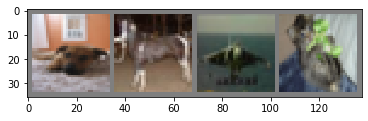

  dog horse plane   cat


In [17]:
#学習データからデータを取得
data_iterator = iter(train_data_loader)
images, labels = data_iterator.next()

#画像を表示
show_image(torchvision.utils.make_grid(images))

#ラベルを表示
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [0]:
#CNN定義

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.layer1 = nn.Linear(16 * 5 * 5, 120)
    self.layer2 = nn.Linear(120, 84)
    self.layer3 = nn.Linear(84, 10)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = self.layer3(x)
    return x

In [0]:
import torch.optim as optimizer

model = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [25]:

for epoch in range(3):

  total_loss = 0.0
  for i, data in enumerate(train_data_loader, 0):
    train_data, teacher_labels = data
    #計算された勾配を削除
    optimizer.zero_grad()
    #予測計算
    outputs = model(train_data)
    #微分計算
    loss = criterion(outputs, teacher_labels)
    loss.backward()
    #勾配を更新
    optimizer.step()
    #誤差を累計
    total_loss += loss.item()

    if i % 2000 == 1999:
      print('学習進捗：[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, total_loss / 2000))
      total_loss = 0.0
  
  print('学習終了')

学習進捗：[1,  2000] loss: 2.173
学習進捗：[1,  4000] loss: 1.840
学習進捗：[1,  6000] loss: 1.683
学習進捗：[1,  8000] loss: 1.598
学習進捗：[1, 10000] loss: 1.537
学習進捗：[1, 12000] loss: 1.462
学習終了
学習進捗：[2,  2000] loss: 1.395
学習進捗：[2,  4000] loss: 1.373
学習進捗：[2,  6000] loss: 1.338
学習進捗：[2,  8000] loss: 1.340
学習進捗：[2, 10000] loss: 1.313
学習進捗：[2, 12000] loss: 1.288
学習終了
学習進捗：[3,  2000] loss: 1.204
学習進捗：[3,  4000] loss: 1.183
学習進捗：[3,  6000] loss: 1.200
学習進捗：[3,  8000] loss: 1.210
学習進捗：[3, 10000] loss: 1.185
学習進捗：[3, 12000] loss: 1.173
学習終了


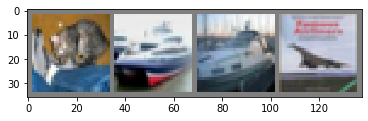

正解教師ラベル：　   cat  ship  ship plane


In [26]:
data_iterator = iter(test_data_loader)
images, labels = data_iterator.next()

#画像表示
show_image(torchvision.utils.make_grid(images))
print('正解教師ラベル：　', ' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [32]:
#テスト
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('予測：　', ' '.join('%5s' % class_names[predicted[j]] for j in range(4)))

予測：　   cat  ship plane plane


In [33]:
#検証
count_when_correct = 0
total = 0
with torch.no_grad():
  for data in test_data_loader:
    test_data, teacher_labels = data
    results = model(test_data)
    _, predicted = torch.max(results.data, 1)
    total += teacher_labels.size(0)
    count_when_correct += (predicted == teacher_labels).sum().item()

print('10000 検証画像に対しての正解率： %d %%' % (100 * count_when_correct / total))

10000 検証画像に対しての正解率： 58 %


In [35]:
#クラス毎の検証結果
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in test_data_loader:
    test_data, teacher_labels = data
    results = model(test_data)
    _, predicted = torch.max(results, 1)
    c = (predicted == teacher_labels).squeeze()

    for i in range(4):
      label = teacher_labels[i]

      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print(' %5s クラスの正解率は： %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))


 plane クラスの正解率は： 63 %
   car クラスの正解率は： 75 %
  bird クラスの正解率は： 51 %
   cat クラスの正解率は： 36 %
  deer クラスの正解率は： 61 %
   dog クラスの正解率は： 48 %
  frog クラスの正解率は： 61 %
 horse クラスの正解率は： 61 %
  ship クラスの正解率は： 59 %
 truck クラスの正解率は： 65 %
